In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import scipy.stats
import tensorflow_probability as tfp
import tensorflow as tf
import seaborn as sns

In [2]:
n = 2
P = np.random.rand(2,2)
P = P @ P.T
L = scipy.linalg.cholesky(P, lower=True)

In [3]:
def commutation_matrix(m, n):
    w = np.arange(m * n).reshape((m, n), order="F").T.ravel(order="F")
    return np.eye(m * n)[w, :]
Kc = commutation_matrix(2,2)
print('Commutation matrix: \n', Kc)

Commutation matrix: 
 [[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]


In [4]:
def logdet_jacobian_neudecker(L, n):
  l = np.diagonal(L)
  exps = np.flip(np.arange(n)+1)
  return n*np.log(2) + np.sum(np.multiply(exps,np.log(np.abs(l))))

In [5]:
def rw_mh_step(Ls_prev_array, step_size, scale, K, jacobian=False):
    # Sampling L from Gaussian density
    Ls_tilde_array = np.random.multivariate_normal(mean=np.zeros(len(Ls_prev_array)), cov=np.eye(len(Ls_prev_array)))
    Ls_tilde_array = Ls_tilde_array * step_size + Ls_prev_array
    # Reshape Ls_tilde and Ls_prev into lower triangular matrices
    Ls_tilde = tfp.math.fill_triangular(Ls_tilde_array, upper=False)
    Ls_prev = tfp.math.fill_triangular(Ls_prev_array, upper=False)
    # Compute precision matrices
    Ps_tilde = Ls_tilde @ tf.transpose(Ls_tilde)
    Ps_prev = Ls_prev @ tf.transpose(Ls_prev)
    # Compute acceptance ratio
    log_gs_tilde = scipy.stats.wishart.logpdf(Ps_tilde, df=K, scale=scale)
    log_gs_prev = scipy.stats.wishart.logpdf(Ps_prev, df=K, scale=scale)
    if jacobian:
        logdet_gs_tilde = logdet_jacobian_neudecker(Ls_tilde, Ls_tilde.shape[0])
        logdet_gs_prev = logdet_jacobian_neudecker(Ls_prev, Ls_prev.shape[0])
        log_gs_tilde += logdet_gs_tilde
        log_gs_prev += logdet_gs_prev
    log_ps_prev = scipy.stats.multivariate_normal.logpdf(Ls_prev_array, mean=Ls_tilde_array, cov=np.eye(len(Ls_tilde_array)))
    log_ps_tilde = scipy.stats.multivariate_normal.logpdf(Ls_tilde_array, mean=Ls_prev_array, cov=np.eye(len(Ls_tilde_array)))
    log_ratio = (log_gs_tilde - log_gs_prev) + (log_ps_prev - log_ps_tilde)
    ratio = np.exp(log_ratio)
    if ratio >= 1 or ratio >= np.random.uniform(0, 1):
        return True, Ls_tilde
    else:
        return False, Ls_prev
def run_sampling(Ls_prev_array, n_samples, step_size, scale, K, jacobian=False, thinning=2, burn_in=100):
    samples = []
    Ls_array = Ls_prev_array
    accepted_samples = []
    for _ in range(n_samples):
        accepted, Ls = rw_mh_step(Ls_array, step_size, scale, K, jacobian=jacobian)
        samples.append(Ls @ tf.transpose(Ls))
        accepted_samples.append(int(accepted))
        Ls_array = tfp.math.fill_triangular_inverse(Ls, upper=False)
        burn_in -= 1
    return accepted_samples, samples

In [6]:
n = 2
n_samples = 10000
V = np.random.rand(n,n)
V = V @ V.T
print('V eigenvalues: ', np.linalg.eigvals(V))
K = 3
Ps_prev = scipy.stats.wishart.rvs(df=K, scale=V, size=1) # Draw a starting sample (P matrix)
Ls_prev_array = tfp.math.fill_triangular_inverse(scipy.linalg.cholesky(Ps_prev, lower=True), upper=False) # Compute P = LL^T and take L (in array form)
accepted_samples_jacobian, samples_jacobian = run_sampling(Ls_prev_array, n_samples, 0.3, V, K, jacobian=True, thinning=4, burn_in=100)
accepted_samples_nojacobian, samples_nojacobian = run_sampling(Ls_prev_array, n_samples, 0.3, V, K, jacobian=False, thinning=4, burn_in=100)
samples_wishart = scipy.stats.wishart.rvs(df=K, scale=V, size=n_samples)
print('Globally accepted samples (jacobian): ',(np.sum(accepted_samples_jacobian)/len(samples_jacobian)) * 100)
print('Globally accepted samples (no jacobian): ',(np.sum(accepted_samples_nojacobian)/len(samples_nojacobian)) * 100)

V eigenvalues:  [1.66300691 0.03785743]
Globally accepted samples (jacobian):  38.690000000000005
Globally accepted samples (no jacobian):  39.31


In [7]:
def plot_mcmc(samples):
  samples_merged = np.empty((n, n), dtype=object)
  samples_wishart_merged = np.empty((n, n), dtype=object)
  samples_mean = np.empty((n, n))
  samples_var = np.empty((n, n))
  samples_wishart_mean = np.empty((n, n))
  samples_wishart_var = np.empty((n, n))
  for i in range(n):
      for j in range(n):
          samples_merged[i,j] = [mat[i, j].numpy() for mat in samples]
          samples_wishart_merged[i,j] = [mat[i, j] for mat in samples_wishart]
          samples_mean[i,j] = np.mean(samples_merged[i, j])
          samples_var[i,j] = np.var(samples_merged[i, j])
          samples_wishart_mean[i,j] = np.mean(samples_wishart_merged[i,j])
          samples_wishart_var[i,j] = np.var(samples_wishart_merged[i,j])
  true_mean = K * V
  def moving_average(x, w):
      return np.convolve(x, np.ones(w), 'valid') / w
  fig, axes = plt.subplots(n, n, figsize=(20, 10), sharex=True, sharey=True)
  for i in range(n):
      for j in range(n):
          ax = axes[i, j]
          mv_avg = moving_average(samples_merged[i,j],10)
          ax.plot(np.arange(0,len(mv_avg),1),mv_avg,linewidth=0.1, marker='o', markersize=.3)
          ax.axhline(true_mean[i,j], color='red')
          ax.axhline(samples_mean[i,j], color='blue')
          ax.set_xlabel(r"iteration")
          ax.set_ylabel(r"$\Lambda_{%d%d}$"%(i,j))
          #ax.set_title(r"Samples from $p(\mathbf{\Lambda}|\mathbf{V},k) $")
  plt.show()
  return samples_mean, samples_var

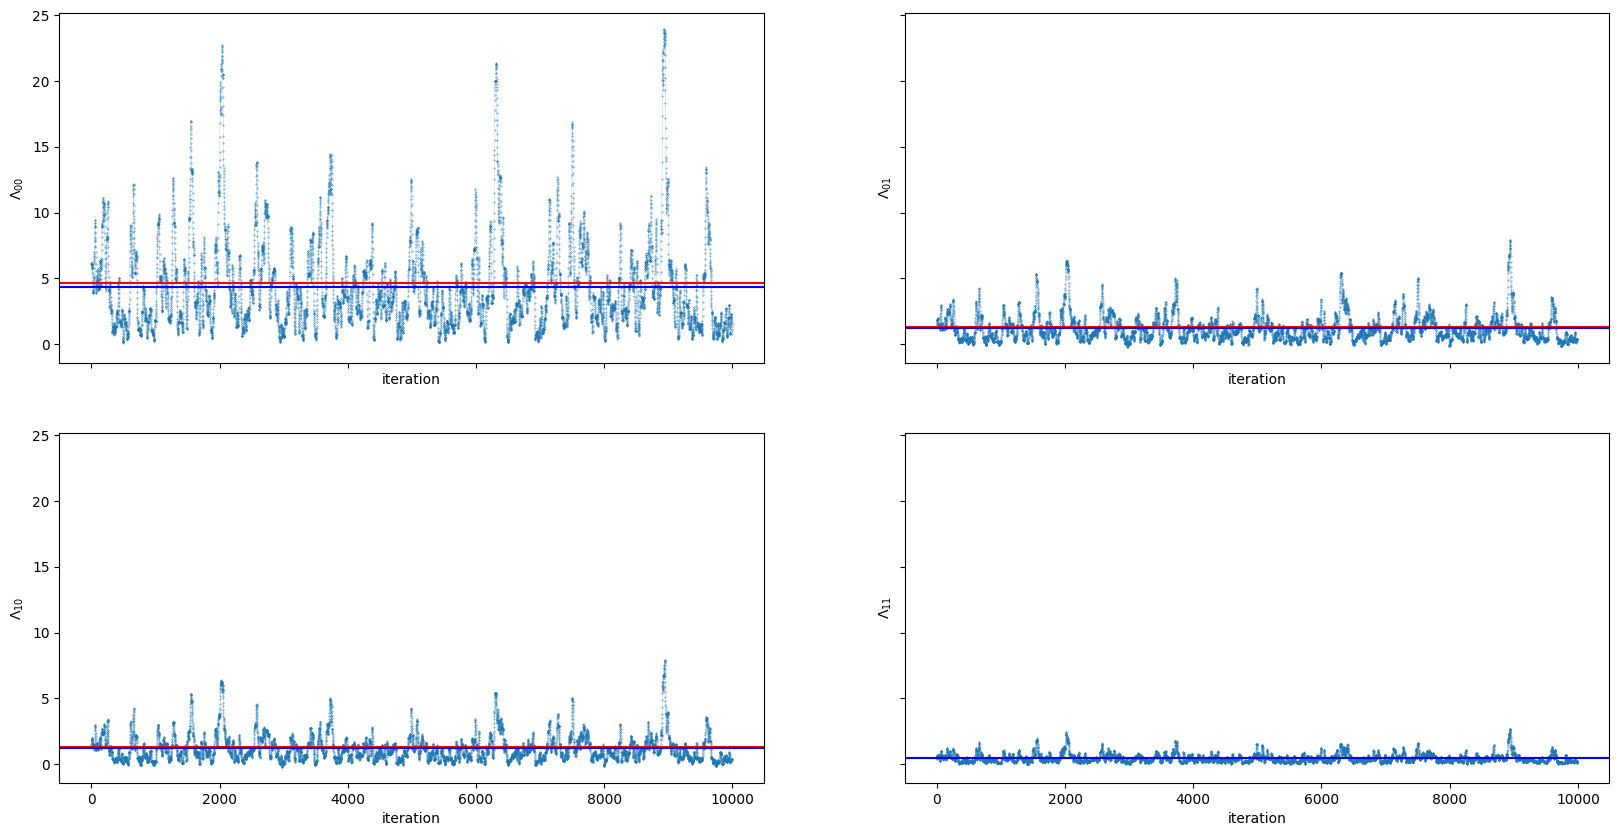

In [12]:
samples_mean_jacobian, samples_var_jacobian = plot_mcmc(samples_jacobian)

In [9]:
samples_mean_jacobian

array([[4.37786911, 1.20779373],
       [1.20779373, 0.4571179 ]])

In [10]:
K*V

array([[4.6162862 , 1.29549875],
       [1.29549875, 0.48630683]])

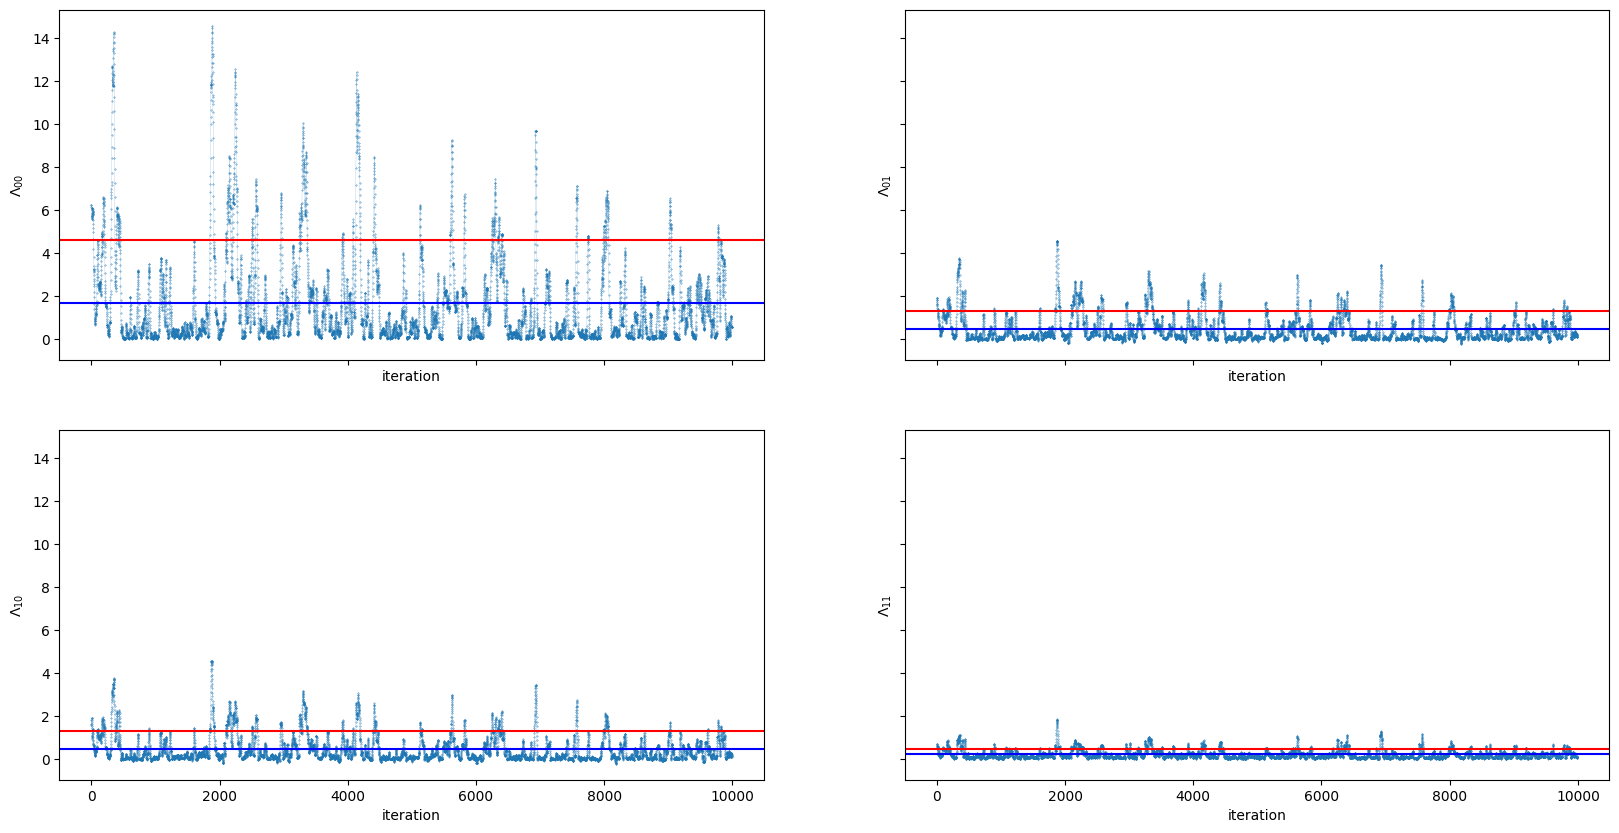

In [11]:
samples_mean, samples_var = plot_mcmc(samples_nojacobian)

In [ ]:
def compute_wishart_variance(df, scale):
    var = np.empty(shape=(scale.shape[0], scale.shape[0]))
    for i in range(scale.shape[0]):
        for j in range(scale.shape[0]):
            var[i,j] = df * (scale[i,j]**2 + scale[i,i]*scale[j,j])
    return var
compute_wishart_variance(K, V)

array([[7.38615638, 5.4989639 ],
       [5.4989639 , 4.64618419]])